In [8]:
#Eager Mode
import tensorflow as tf

tf.enable_eager_execution()    
import tensorflow.contrib.eager as tfe
print("Eager execution: {}".format(tf.executing_eagerly())) 

Eager execution: True


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras import models
from tensorflow.python.keras.preprocessing import image as kp_image
import IPython.display

# Feature Reconstruction

This document is for reconstructing features captured by CNN. In this case, we visualize the information of different layers in the CNN by reconstructing the input image. (Note: Implementation is based on **tensorflow eager mode**)

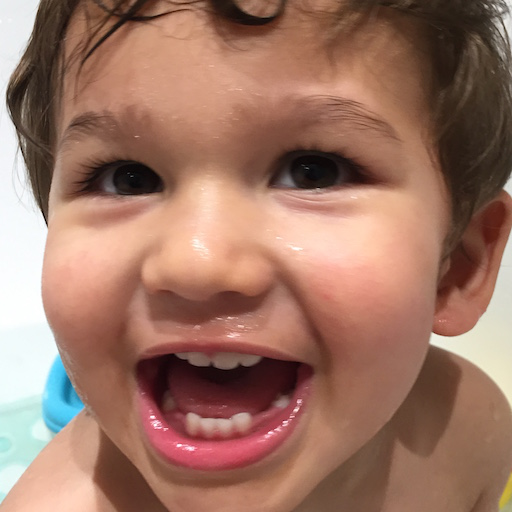

In [10]:
height=512
width=512

content_image_path = 'content.png'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

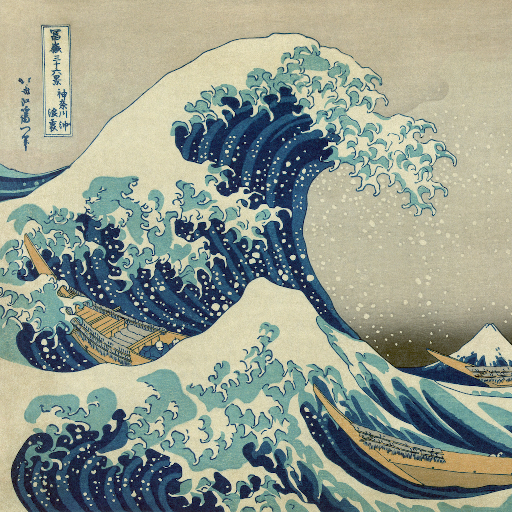

In [11]:
height=512
width=512

style_image_path = 'style.png'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

## Step 1: Load and preprocess images

In [0]:
def load_and_preprocess_img(image_path,height,width):
  """This function will load and resize image.
  
  Arguments:
    image_path: the path of image
    height: image height
    width: image width
      
  Returns:
    returns image pixel numpy array and image itself
  """
  
  #load and resize
  img = Image.open(image_path)
  img = img.resize((width, height))  
  
  #get raw pixel array
  img_array=kp_image.img_to_array(img)  #range: 0-255
  img_array=np.expand_dims(img_array, axis=0)
  img_array=tf.keras.applications.vgg19.preprocess_input(img_array,mode='tf')  #normalize for VGG19: [-1,1]
  
  return img_array,img

## Step 2: Get features from hidden layers

In [0]:
def hidden_model(layer_name):
  """This function will build a model which would output features from a hidden layer
  
  Arguments:
    layer_name: a hidden layer name
      
  Returns:
    returns model which outputs the hidden feature
  """
  model = tf.keras.applications.vgg19.VGG19(input_shape=(512, 512, 3), include_top=False)
  model.trainable = False     
  hidden_output = model.get_layer(layer_name).output
  return models.Model(model.input, hidden_output) 

## Step 3: Compute loss and gradients w.r.t model inputs

In [0]:
def gram_matrix(feature_tensor):
  """This function will compute gram matrix based on Gatys paper
  
  Arguments:
    feature_tensor: feature tensor
      
  Returns:
    returns gram matrix
  
  Note:
    In order to reduce computation somehow, we could normalize loss. 
    This idea comes from tensorflow tutorial:
    https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  
  """
  channel = int(feature_tensor.shape[-1])
  feature_2d=tf.reshape(feature_tensor, [-1, channel])
  n=feature_2d.shape[0]
  feature_2d=tf.matmul(feature_2d, feature_2d, transpose_a=True)
  return feature_2d/tf.cast(n,tf.float32)

In [0]:
def compute_loss(model,init_image,target_image,loss_type):
  """This function will compute content/style loss
  
  Arguments:
    model: the hidden model we build
    init_image: initial image(numpy array)
    target_image: target image(numpy array)
    loss_type: content or style
      
  Returns:
    returns loss
  """
  init_features = model(init_image)
  target_features = model(target_image)
  
  if loss_type=='content':
      return tf.reduce_mean(tf.square(init_features-target_features))
  elif loss_type=='style':
      init_gram=gram_matrix(init_features)
      target_gram=gram_matrix(target_features)
      #_,h,w,N,=target_features.shape
      #M=h*w
      #norm=tf.cast(tf.divide(1,tf.multiply(4,tf.multiply(tf.pow(M,2),tf.pow(N,2)))),tf.float32)
      style_loss=tf.reduce_mean(tf.square(init_gram -target_gram))
      #return tf.multiply(norm,style_loss)
      return style_loss

In [0]:
def compute_grads(par):
  """This function will compute grads w.r.t initial image
  
  Arguments:
    par: a set which contains parameters
      
  Returns:
    returns gradients and loss
  """
  with tf.GradientTape() as tape: 
    loss = compute_loss(**par)
  return tape.gradient(loss, par['init_image']), loss

## Step 4: Reconstruct features

In [0]:
def feature_reconstruct(image_path,height,width,layer_name,opt,loss_type,iterations):
  """This function will reconstruct feature in a hidden layer
  
  Arguments:
    image_path: the path of image
    height: image height
    width: image width
    layer_name: a hidden layer name
    opt: tf.train optimizer
    loss_type: content or style
    iterations: the number of iterations
    
  Returns:
    returns reconstruction loss and image
    
  Note: Display part idea comes from tensorflow tutorial: 
        https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  """
  
  #get hidden model
  model = hidden_model(layer_name) 
  for layer in model.layers:
    layer.trainable = False
  
  #create white noise image and load target image
  target_image,_= load_and_preprocess_img(image_path,height,width)
  init_image = np.random.uniform(-1, 1, (1, height, width, 3)).astype('uint8')
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  #for compute_grads
  par = {'model': model,
        'init_image': init_image,
        'target_image': target_image,
        'loss_type': loss_type}
  
  #backpropogate and show results
  imgs = []
  best_loss, best_img = float('inf'), None
  for i in range(iterations):
    grads, loss = compute_grads(par)
    loss= loss.numpy()
    opt.apply_gradients([(grads, init_image)])
    
    if loss < best_loss:
      best_loss = loss
      best_img =(init_image.numpy()[0,:,:,:]+1)*127.5   #[-1,1] reverses to 0-255
      best_img=best_img.astype('uint8')
    
    if i % 20==0:
      img_array=(init_image.numpy()[0,:,:,:]+1)*127.5   #[-1,1] reverses to 0-255
      img_array=img_array.astype('uint8')
      imgs.append(img_array)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(img_array))
      print('Iteration: '+str(i))
      print('Loss: '+ str(loss))
    
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(20,10))
  for i,img in enumerate(imgs):
      plt.subplot(7,8,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([]) 
      
  return best_loss, best_img

## Step 5: Run 

### content reconstruction

In [0]:
image_path='content.png'
height=512
width=512
layer_name='block2_conv2'
opt=tf.train.AdamOptimizer(learning_rate=0.01,beta1=0.99,epsilon=1e-8)
loss_type='content'
iterations=200

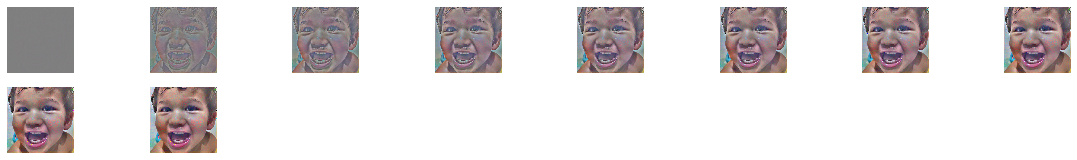

In [87]:
best_loss,best_img=feature_reconstruct(image_path,height,width,layer_name,opt,loss_type,iterations)

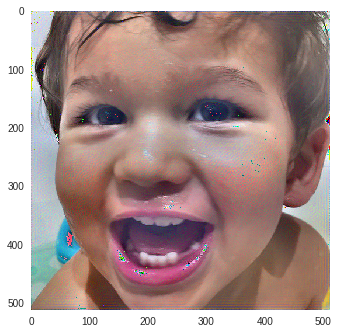

In [88]:
plt.imshow(best_img)
plt.grid(False)

### Style construction

In [0]:
image_path='style.png'
height=512
width=512
layer_name='block5_conv2'  #it captures texture for style image
opt=tf.train.AdamOptimizer(learning_rate=0.01,beta1=0.99,epsilon=1e-8)
loss_type='style'
iterations=200

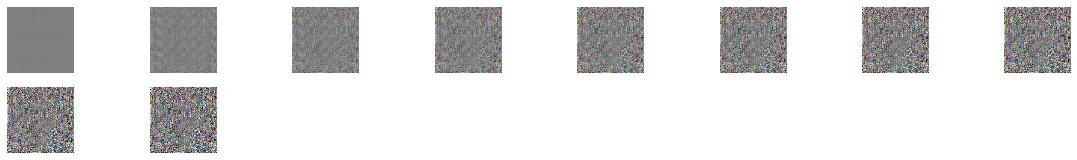

In [97]:
best_loss,best_img=feature_reconstruct(image_path,height,width,layer_name,opt,loss_type,iterations)

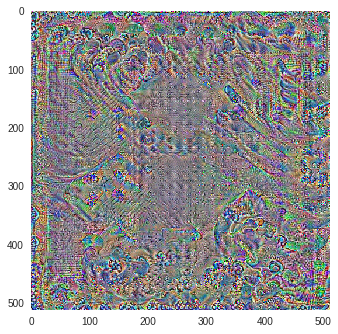

In [98]:
plt.imshow(best_img)
plt.grid(False)

## TO DO 

* `gram_matrix`: if we add normalize term into the style loss, the result would be Inf. 
* `style_loss` and `content_loss`: should we use tf.reduce_mean instead of tf.reduce_sum? Is it reasonable? 
* `feature_reconstruct`: we should tune parameters for feature reconstruction. It seems that different layers should be applied with different optimizer, learning rate and etc. 